In [1]:
## general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output


data_dir = 'data/LFW/lfw-deepfunneled/lfw-deepfunneled'

  Using cached mtcnn-0.1.1-py3-none-any.whl (2.3 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("data/LFW/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("data/LFW/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("data/LFW/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("data/LFW/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("data/LFW/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("data/LFW/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("data/LFW/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("data/LFW/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("data/LFW/peopleDevTrain.csv")

In [5]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

832
859


C:\Users\Harry Parker\AppData\Local\Temp\ipykernel_27208\3389311693.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
C:\Users\Harry Parker\AppData\Local\Temp\ipykernel_27208\3389311693.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\Harry Parker\AppData\Local\Temp\ipykernel_27208\3389311693.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


In [6]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "data/LFW/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: >

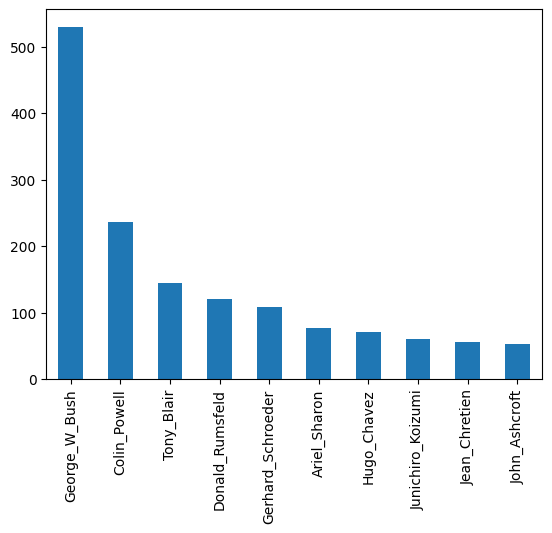

In [7]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [8]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


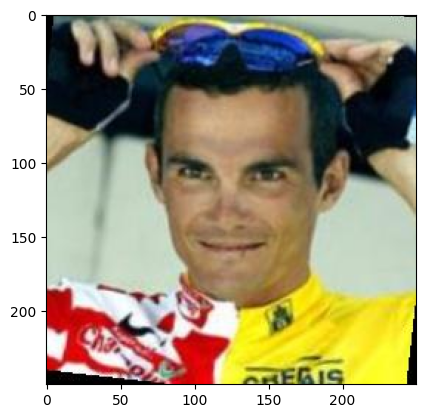

In [9]:
im = Image.open("data/LFW/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

1/1 [==============================] - 0s 138ms/step


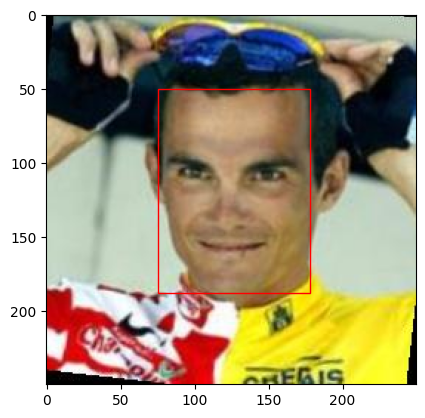

In [10]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("data/LFW/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
#for key in keypoints:
    #rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    #ax.add_patch(rect_key)
# Show the plots
plt.show()

In [13]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
def get_number_default_boxes(aspect_ratios, extra_box_for_ar_1=True):
    """ Get the number of default boxes for each grid cell based on the number of aspect ratios
    and whether to add a extra box for aspect ratio 1
    Args:
    - aspect_ratios: A list containing the different aspect ratios of default boxes.
    - extra_box_for_ar_1: Whether to add a extra box for aspect ratio 1.
    Returns:
    - An integer for the number of default boxes.
    """
    num_aspect_ratios = len(aspect_ratios)
    return num_aspect_ratios + 1 if (1.0 in aspect_ratios) and extra_box_for_ar_1 else num_aspect_ratios

# LAYERS


In [ ]:
import tensorflow as tf
from keras.layers import Layer
from utils import ssd_utils


class DecodeSSDPredictions(Layer):
    def __init__(
        self,
        input_size,
        nms_max_output_size=400,
        confidence_threshold=0.01,
        iou_threshold=0.45,
        num_predictions=10,
        **kwargs
    ):
        self.input_size = input_size
        self.nms_max_output_size = nms_max_output_size
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.num_predictions = num_predictions
        super(DecodeSSDPredictions, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DecodeSSDPredictions, self).build(input_shape)

    def call(self, inputs):
        y_pred = ssd_utils.decode_predictions(
            y_pred=inputs,
            input_size=self.input_size,
            nms_max_output_size=self.nms_max_output_size,
            confidence_threshold=self.confidence_threshold,
            iou_threshold=self.iou_threshold,
            num_predictions=self.num_predictions
        )
        return y_pred

    def get_config(self):
        config = {
            'input_size': self.input_size,
            'nms_max_output_size': self.nms_max_output_size,
            'confidence_threshold': self.confidence_threshold,
            'iou_threshold': self.iou_threshold,
            'num_predictions': self.num_predictions,
        }
        base_config = super(DecodeSSDPredictions, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [14]:
import numpy as np
from keras.models import Model
from keras.layers import MaxPool2D, Conv2D, Reshape, Concatenate, Activation
from keras.regularizers import l2
from keras.applications import VGG16
from custom_layers import L2Normalization, DefaultBoxes, DecodeSSDPredictions

def SSD_VGG16(config, label_maps):
    """ This network follows the official caffe implementation of SSD: https://github.com/chuanqi305/ssd
    1. Changes made to VGG16 config D layers:
        - fc6 and fc7 is converted into convolutional layers instead of fully connected layers specify in the VGG paper
        - atrous convolution is used to turn fc6 and fc7 into convolutional layers
        - pool5 size is changed from (2, 2) to (3, 3) and its strides is changed from (2, 2) to (1, 1)
        - l2 normalization is used only on the output of conv4_3 because it has different scales compared to other layers. To learn more read SSD paper section 3.1 PASCAL VOC2007
    2. In Keras:
        - padding "same" is equivalent to padding 1 in caffe
        - padding "valid" is equivalent to padding 0 (no padding) in caffe
        - Atrous Convolution is referred to as dilated convolution in Keras and can be used by specifying dilation rate in Conv2D
    3. The name of each layer in the network is renamed to match the official caffe implementation

    Args:
        - config: python dict as read from the config file
        - label_maps: A python list containing the classes

    Returns:
        - A keras version of SSD300 with VGG16 as backbone network.

    Code References:
        - https://github.com/chuanqi305/ssd
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/models/keras_ssd300.py

    Paper References:
        - Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016).
          SSD: Single Shot MultiBox Detector. https://arxiv.org/abs/1512.02325
    """
    model_config = config["model"]
    input_shape = (model_config["input_size"], model_config["input_size"], 3)
    num_classes = len(label_maps) + 1  # for background class
    l2_reg = model_config["l2_regularization"]
    kernel_initializer = model_config["kernel_initializer"]
    default_boxes_config = model_config["default_boxes"]
    extra_box_for_ar_1 = model_config["extra_box_for_ar_1"]

    # construct the base network and extra feature layers
    base_network = VGG16(
        input_shape=input_shape,
        classes=num_classes,
        weights='imagenet',
        include_top=False
    )
    base_network = Model(inputs=base_network.input, outputs=base_network.get_layer('block5_conv3').output)
    base_network.get_layer("input_1")._name = "input"
    for layer in base_network.layers:
        if "pool" in layer.name:
            new_name = layer.name.replace("block", "")
            new_name = new_name.split("_")
            new_name = f"{new_name[1]}{new_name[0]}"
        else:
            new_name = layer.name.replace("conv", "")
            new_name = new_name.replace("block", "conv")
        base_network.get_layer(layer.name)._name = new_name
        base_network.get_layer(layer.name)._kernel_initializer = "he_normal"
        base_network.get_layer(layer.name)._kernel_regularizer = l2(l2_reg)
        layer.trainable = False  # each layer of the base network should not be trainable

    def conv_block_1(x, filters, name, padding='valid', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters,
            kernel_size=(3, 3),
            strides=strides,
            activation='relu',
            padding=padding,
            dilation_rate=dilation_rate,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=name)(x)

    def conv_block_2(x, filters, name, padding='valid', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters,
            kernel_size=(1, 1),
            strides=strides,
            activation='relu',
            padding=padding,
            dilation_rate=dilation_rate,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=name)(x)

    pool5 = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding="same",
        name="pool5")(base_network.get_layer('conv5_3').output)

    fc6 = conv_block_1(x=pool5, filters=1024, padding="same", dilation_rate=(6, 6), name="fc6")
    fc7 = conv_block_2(x=fc6, filters=1024, padding="same", name="fc7")
    conv8_1 = conv_block_2(x=fc7, filters=256, padding="valid", name="conv8_1")
    conv8_2 = conv_block_1(x=conv8_1, filters=512, padding="same", strides=(2, 2), name="conv8_2")
    conv9_1 = conv_block_2(x=conv8_2, filters=128, padding="valid", name="conv9_1")
    conv9_2 = conv_block_1(x=conv9_1, filters=256, padding="same", strides=(2, 2), name="conv9_2")
    conv10_1 = conv_block_2(x=conv9_2, filters=128, padding="valid", name="conv10_1")
    conv10_2 = conv_block_1(x=conv10_1, filters=256, padding="valid", name="conv10_2")
    conv11_1 = conv_block_2(x=conv10_2, filters=128, padding="valid", name="conv11_1")
    conv11_2 = conv_block_1(x=conv11_1, filters=256, padding="valid", name="conv11_2")

    model = Model(inputs=base_network.input, outputs=conv11_2)

    # construct the prediction layers (conf, loc, & default_boxes)
    scales = np.linspace(
        default_boxes_config["min_scale"],
        default_boxes_config["max_scale"],
        len(default_boxes_config["layers"])
    )
    mbox_conf_layers = []
    mbox_loc_layers = []
    mbox_default_boxes_layers = []
    for i, layer in enumerate(default_boxes_config["layers"]):
        num_default_boxes = get_number_default_boxes(
            layer["aspect_ratios"],
            extra_box_for_ar_1=extra_box_for_ar_1
        )
        x = model.get_layer(layer["name"]).output
        layer_name = layer["name"]

        # conv4_3 has different scales compared to other feature map layers
        if layer_name == "conv4_3":
            layer_name = f"{layer_name}_norm"
            x = L2Normalization(gamma_init=20, name=layer_name)(x)

        layer_mbox_conf = Conv2D(
            filters=num_default_boxes * num_classes,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_conf")(x)
        layer_mbox_conf_reshape = Reshape((-1, num_classes), name=f"{layer_name}_mbox_conf_reshape")(layer_mbox_conf)
        layer_mbox_loc = Conv2D(
            filters=num_default_boxes * 4,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_loc")(x)
        layer_mbox_loc_reshape = Reshape((-1, 4), name=f"{layer_name}_mbox_loc_reshape")(layer_mbox_loc)
        layer_default_boxes = DefaultBoxes(
            image_shape=input_shape,
            scale=scales[i],
            next_scale=scales[i+1] if i+1 <= len(default_boxes_config["layers"]) - 1 else 1,
            aspect_ratios=layer["aspect_ratios"],
            variances=default_boxes_config["variances"],
            extra_box_for_ar_1=extra_box_for_ar_1,
            name=f"{layer_name}_default_boxes")(x)
        layer_default_boxes_reshape = Reshape((-1, 8), name=f"{layer_name}_default_boxes_reshape")(layer_default_boxes)
        mbox_conf_layers.append(layer_mbox_conf_reshape)
        mbox_loc_layers.append(layer_mbox_loc_reshape)
        mbox_default_boxes_layers.append(layer_default_boxes_reshape)

    # concentenate class confidence predictions from different feature map layers
    mbox_conf = Concatenate(axis=-2, name="mbox_conf")(mbox_conf_layers)
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
    # concentenate object location predictions from different feature map layers
    mbox_loc = Concatenate(axis=-2, name="mbox_loc")(mbox_loc_layers)
    # concentenate default boxes from different feature map layers
    mbox_default_boxes = Concatenate(axis=-2, name="mbox_default_boxes")(mbox_default_boxes_layers)
    # concatenate confidence score predictions, bounding box predictions, and default boxes
    predictions = Concatenate(axis=-1, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_default_boxes])

    return Model(inputs=base_network.input, outputs=predictions)

In [18]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('data/LFW/working/',dir_name)):
            shutil.os.mkdir(os.path.join('data/LFW/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('data/LFW/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('data/LFW/working/',dir_name,data_type))
        path_from = os.path.join('data/LFW/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('data/LFW/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [19]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [20]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('data/LFW/working/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('data/LFW/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('data/WIDERFace/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [27]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678,
                                             # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

C:\Users\Harry Parker\AppData\Local\Temp\ipykernel_27208\1229753785.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Bush_history = Bush_classifier.fit_generator(Bush_training_set,


Epoch 1/8
678/678 [==============================] - 28s 40ms/step - loss: 0.5376 - accuracy: 0.7345 - val_loss: 0.5881 - val_accuracy: 0.6941


In [28]:
# Save entire model to a HDF5 file
Bush_classifier.save('../output/my_model.h5')

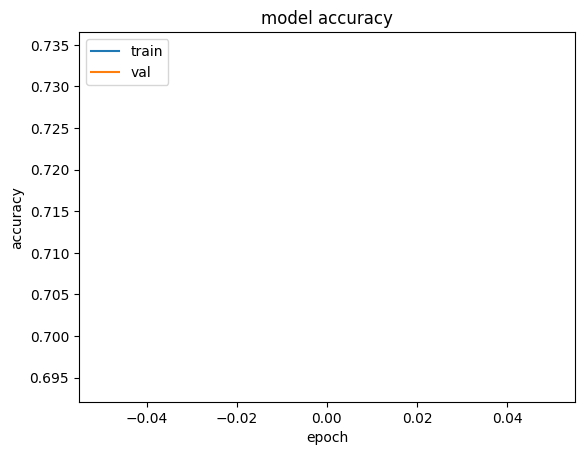

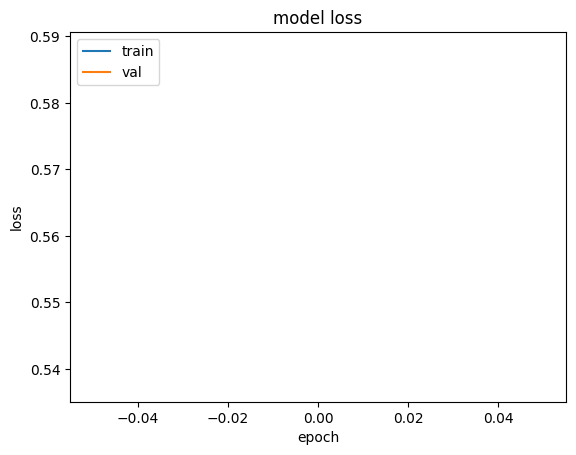

In [30]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()